In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [2]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Augmentation

### Define Augmentation Function


In [3]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
angles = [0, 45, 90, 135]

for i in range(len(data)):
    pass

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [ ]:
# Preprocessing 1 Ekualisasi Histogram
def histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = np.zeros(256, dtype=int)

    for i in range(baris):
        for j in range(kolom):
            intensitas = int(image[i, j])
            frekuensi_histogram[intensitas] += 1

    return frekuensi_histogram

def equalize_histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = histogram(image)
    probabilitas = frekuensi_histogram / (baris * kolom)
    distribusi_kumulatif = np.zeros(256)
    distribusi_kumulatif[0] = probabilitas[0]
    for i in range(1, 256):
        distribusi_kumulatif[i] = distribusi_kumulatif[i-1] + probabilitas[i]

    image_equalized = np.zeros_like(image)
    for i in range(baris):
        for j in range(kolom):
            intensitas = image[i, j]
            image_equalized[i, j] = int(distribusi_kumulatif[intensitas] * 255)

    return image_equalized

# Preprocessing 2 Sharpening
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

def convolution(image, kernel):
    padding = kernel.shape[0] // 2
    input_image = np.pad(image, padding, mode='constant')

    convolution_image = np.zeros_like(image).astype(np.float32)

    tinggi, lebar = image.shape

    for i in range(tinggi):
        for j in range(lebar):
            convolution_image[i, j] = np.sum(input_image[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return convolution_image

# Preprocessing 3
def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
    
    return median

def medianfilter(image, kernel):
    tinggi_image, lebar_image = image.shape
    tinggi_kernel, lebar_kernel = kernel.shape

    tinggi_tenggah = int((tinggi_kernel - 1) / 2)
    lebar_tengah = int((lebar_kernel - 1) / 2)

    padding_kiri = lebar_tengah
    padding_kanan = lebar_kernel - lebar_tengah
    padding_atas = tinggi_tenggah
    padding_bawah = tinggi_kernel - tinggi_tenggah

    padded_image = np.pad(image, ((padding_atas, padding_bawah), (padding_kiri, padding_kanan)), mode='edge')

    result = np.zeros([tinggi_image, lebar_image])

    for i in range(tinggi_image):
        for j in range(lebar_image):
            temp = np.zeros(len(kernel) * len(kernel))
            index = 0
            for k in range(tinggi_kernel):
                for l in range(lebar_kernel):
                    temp[index] += padded_image[i + k, j + l]
                    index += 1
                    result[i, j] = median(temp)

    return result

### Preprocessing

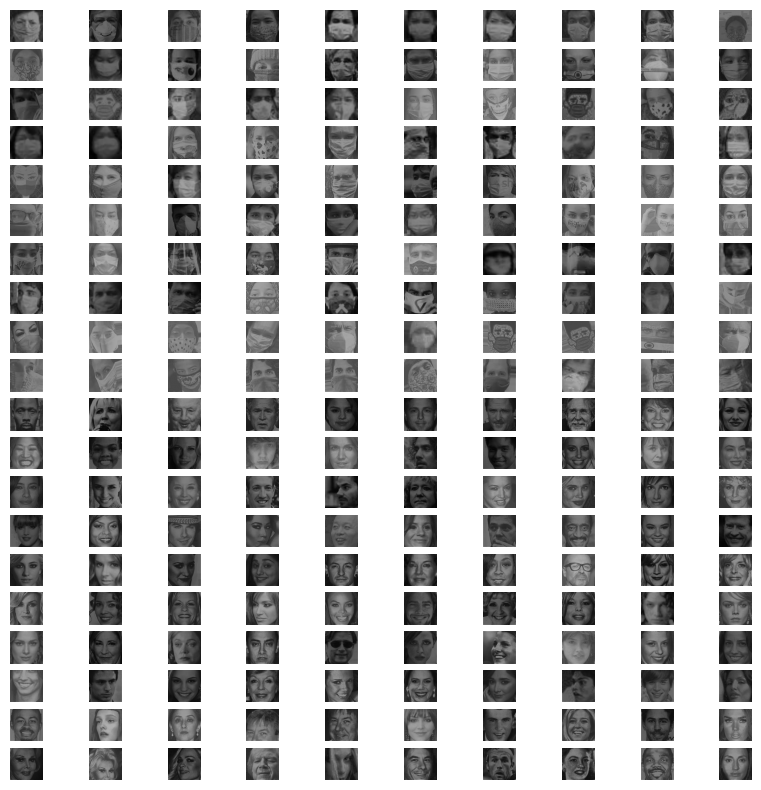

In [8]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
    img = equalize_histogram(data[i])
    img_proc = convolution(img, kernel)
    dataPreprocessed.append(img_proc)

plt.figure(figsize=(10, 10))
for i in range(len(dataPreprocessed)):
    plt.subplot(20, 10, i + 1)
    plt.imshow(dataPreprocessed[i], cmap='gray')
    plt.axis('off')

plt.show()

### Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [ ]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [ ]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [ ]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [ ]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [ ]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [ ]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1163.png,withMask,23.228948,40.050451,19.560803,44.256480,0.432806,0.297220,0.432014,0.286512,...,0.000957,0.000583,0.030745,0.024603,0.030936,0.024136,0.997849,0.996284,0.998188,0.995894
1,1174.png,withMask,72.544851,151.301189,83.090361,146.284076,0.430827,0.295415,0.433512,0.303481,...,0.001150,0.000757,0.035167,0.026990,0.033913,0.027507,0.993321,0.986087,0.992379,0.986549
2,1175.png,withMask,183.533847,230.287189,59.253815,241.353365,0.322931,0.206278,0.364090,0.205386,...,0.000892,0.000455,0.026764,0.021256,0.029869,0.021330,0.983042,0.978688,0.994531,0.977665
3,1203.png,withMask,64.992707,145.520556,74.437157,126.541475,0.351959,0.202755,0.318781,0.205749,...,0.000549,0.000339,0.024394,0.018229,0.023432,0.018419,0.993987,0.986527,0.993127,0.988284
4,1361.png,withMask,15.257510,39.505556,24.575518,38.947662,0.495819,0.336721,0.469621,0.332118,...,0.001372,0.000884,0.039769,0.029810,0.037039,0.029740,0.998599,0.996371,0.997741,0.996422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,967.png,withoutMask,34.350667,84.906082,54.569398,89.105869,0.412141,0.318510,0.452207,0.305998,...,0.006331,0.005070,0.074992,0.071673,0.079567,0.071201,0.996730,0.991915,0.994811,0.991515
196,972.png,withoutMask,120.678378,216.022161,106.779582,230.514992,0.307036,0.181914,0.305310,0.181778,...,0.000621,0.000359,0.025179,0.019101,0.024921,0.018938,0.988891,0.980102,0.990180,0.978767
197,973.png,withoutMask,85.750490,168.769552,75.264739,145.742859,0.338180,0.217780,0.342620,0.212385,...,0.001209,0.000748,0.034079,0.027471,0.034764,0.027348,0.992159,0.984552,0.993116,0.986660
198,998.png,withoutMask,193.623486,345.062531,178.920948,367.483363,0.321996,0.212249,0.341696,0.208562,...,0.001801,0.001113,0.039843,0.033531,0.042434,0.033355,0.982269,0.968412,0.983615,0.966360


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

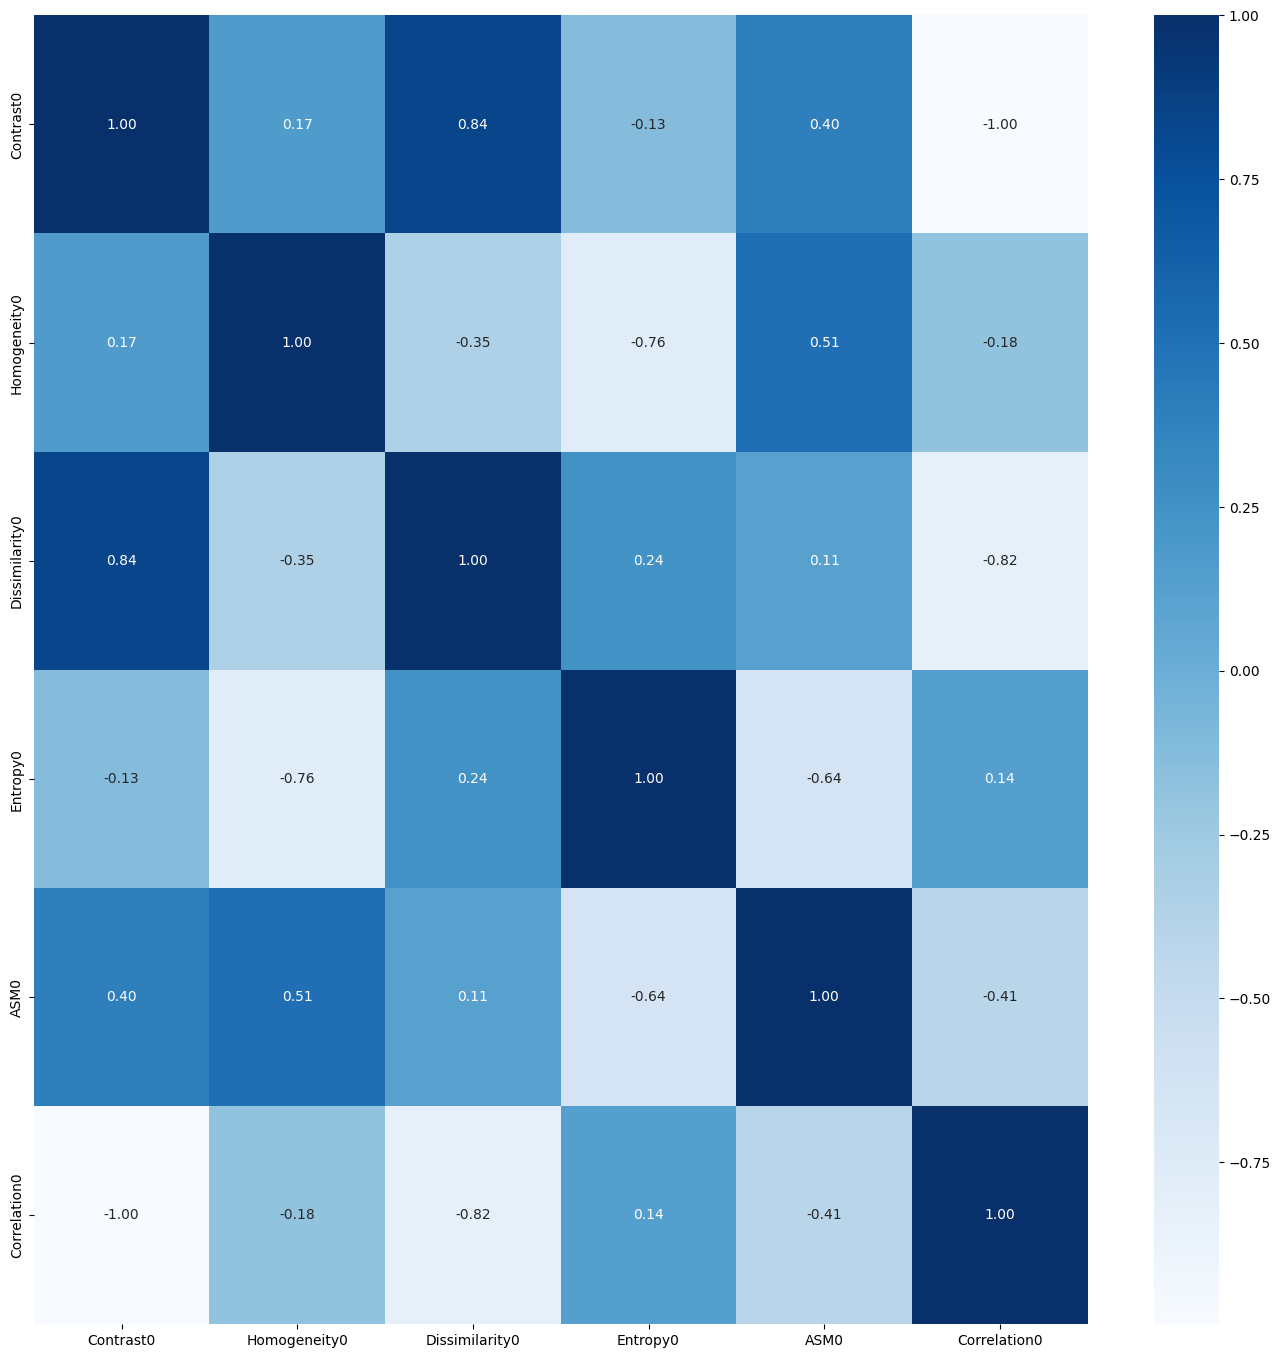

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 6)
(40, 6)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [ ]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

    withMask       0.96      0.97      0.97        79
 withoutMask       0.97      0.96      0.97        81

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

[[77  2]
 [ 3 78]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.77      0.81      0.79        21
 withoutMask       0.78      0.74      0.76        19

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40

[[17  4]
 [ 5 14]]
Accuracy: 0.775


### Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

    withMask       0.90      0.77      0.83        79
 withoutMask       0.80      0.91      0.86        81

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160

[[61 18]
 [ 7 74]]
Accuracy: 0.84375

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.83      0.90      0.86        21
 withoutMask       0.88      0.79      0.83        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[19  2]
 [ 4 15]]
Accuracy: 0.85


### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

    withMask       0.92      0.85      0.88        79
 withoutMask       0.86      0.93      0.89        81

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

[[67 12]
 [ 6 75]]
Accuracy: 0.8875

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.82      0.86      0.84        21
 withoutMask       0.83      0.79      0.81        19

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40

[[18  3]
 [ 4 15]]
Accuracy: 0.825


## Evaluation With Confusion Matrix

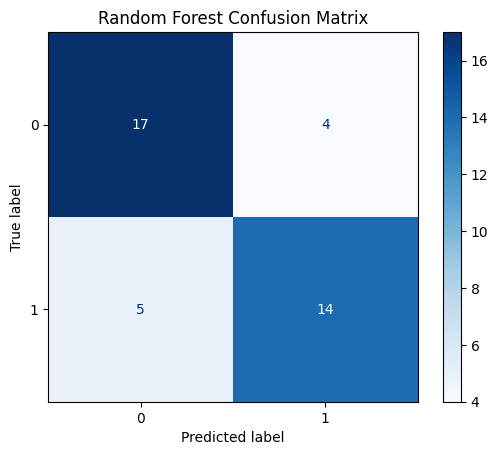

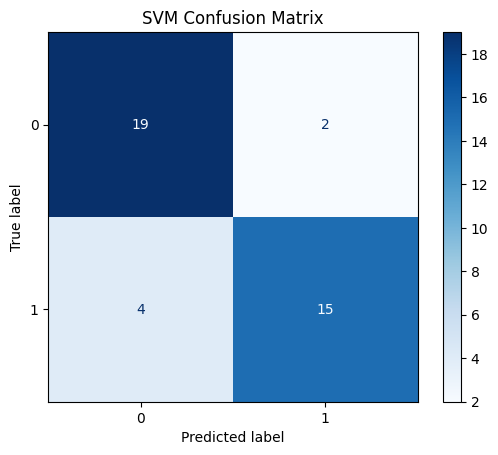

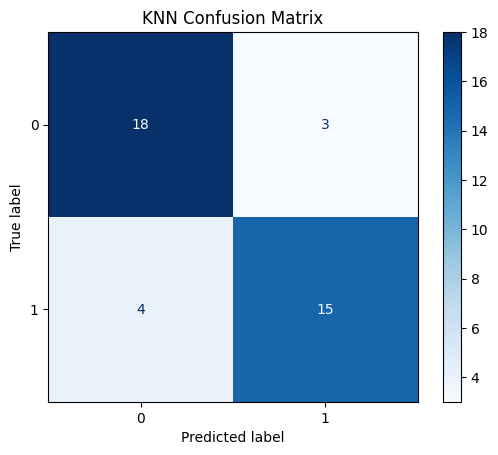

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")